# RENT applied to a regression problem

This Jupyter notebook illustrates how to apply RENT feature selection for **regression problems**. The procedure is according to the manscript published at arXiv.org
[RENT -- Repeated Elastic Net Technique for Feature Selection](https://arxiv.org/abs/2009.12780).

For an example on how to use RENT for feature selection on a **binary classification** problem, please have a look this [Jupyter Notebook](https://github.com/NMBU-Data-Science/RENT/blob/master/src/RENT/Classification_example.ipynb).
The RENT-flow for classification and regression problems is similar --- a more detailed description on single functions is provided in the classification notebook. Specialities for regression problems are described in this notebook.

## Content

1. [Create a scikit-learn regression dataset](#Create-a-scikit-learn-regression-dataset)
2. [Define RENT ensemble for regression](#Define-RENT-ensemble-for-regression)
3. [Train RENT ensemble and inspect results](#Train-RENT-ensemble-and-inspect-results)
4. [Set selection criteria cutoffs](#Set-selection-criteria-cutoffs)
5. [Check performance using only selected features](#Check-performance-using-only-selected-features)
6. [Validation study regarding the features selected by RENT](#Validation-study-regarding-the-features-selected-by-RENT)
7. [Investigation of absolute prediction errors](#Investigation-of-absolute-prediction-errors)
8. [Stability analysis of RENT](#Stability-analysis-of-RENT)

First, we import RENT and create a synthetic regression dataset with scikit-learn. The dataset is split into a separate train and test dataset --- feature selection will be performed on the train dataset. A linear regression model will evaluate the performance of the selected features on an unseen test dataset.

In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import sys
sys.path.append('../src')
from RENT import RENT, stability

import warnings
warnings.filterwarnings("ignore")

C:\Users\annaj\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Create a scikit-learn regression dataset

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

data = make_regression(n_samples=250, n_features=1000, n_informative=20, random_state=0, shuffle=False)

my_data = pd.DataFrame(data[0])
my_target = data[1]
my_feat_names = ['f{0}'.format(x+1) for x in range(len(my_data.columns))]

train_data, test_data, train_labels, test_labels = train_test_split(my_data, my_target, test_size=0.3, random_state=0)

In [3]:
train_data.head()

0         1         2         3         4         5         6    \
106  2.149121  0.691826  0.486547 -0.019764  0.302424  1.277061  1.579083   
243 -2.049990  0.520697 -0.251004  0.063952 -0.186038 -1.942276 -1.503859   
4    0.613349  1.843700  0.271091  1.136448 -1.738332  0.707135  0.030386   
219  0.323499 -0.846183  1.995049  1.909987  1.535392 -1.265578  1.194761   
61   1.499146  0.786124  1.458277  1.060691  1.457692  0.459417  0.990046   

          7         8         9         10        11        12        13   \
106 -1.364472  0.117825 -0.244706  2.205690  0.584233 -0.811286 -0.884548   
243 -1.951937 -0.086721 -0.197701 -0.616347  0.953608 -0.144764  1.161990   
4    0.765002  0.867665 -2.256250 -0.443603 -0.670023  0.152164 -1.940533   
219 -2.084609 -2.026839  0.331927 -0.426118  0.449704 -0.148286  0.653601   
61   0.036754 -0.091988 -0.415007  1.112156 -1.899117 -0.002977  0.973658   

          14        15        16        17        18        19        20   \
106  0.501877 -0.962827 -0.691779  0.518337  0.222326 -2.408070 -0.625869   
243 -1.550197  0.672744  0.377486  1.360723  1.405802  0.528380 -0.072739   
4   -1.090509  1.001921  0.176892 -1.088015 -0.253217  1.098273 -1.839567   
219 -0.121109 -0.196609  0.275921 -0.134049 -1.508558 -0.429518 -0.452594   
61   0.581903 -0.377255 -0.310067 -0.284806  0.264019 -0.351630 -0.409284   

          21        22        23        24        25        26        27   \
106 -0.222027 -1.197066 -0.451108  0.181859  1.039101  0.165688 -0.119562   
243 -1.029145 -0.994496 -1.105304 -0.068084 -0.665437  1.254067 -0.502795   
4   -0.211429 -0.229663  0.186979  0.503779  1.910343  0.553781 -0.587481   
219 -0.369132 -0.254351 -0.421597  0.567299 -1.129076 -0.698770  0.883576   
61  -2.093585 -2.258443  0.378441  1.226664 -0.656646 -0.036502  0.375841   

          28        29        30        31        32        33        34   \
106 -0.427894 -0.338002  0.709603 -1.252337 -1.000163  2.183775  1.115316   
243  0.195497 -0.092156  0.622120 -1.188206 -0.736452 -0.338902  0.742297   
4    1.257950 -0.858668  0.436187  1.571463  1.077315  0.811090 -2.231538   
219 -1.125608 -0.870880 -1.730482 -0.890559 -0.629409 -0.392883  1.766322   
61  -1.157412 -1.660873  0.336066 -0.417479  1.787201 -0.576220 -0.944968   

          35        36        37        38        39        40        41   \
106 -0.345772  0.279497 -0.342471 -0.418153  0.534026 -0.929469 -2.675504   
243  0.798535  0.608720  0.327368  0.806622 -0.451537  0.949753  1.508314   
4   -0.101003 -0.587375  1.324868  0.840648  0.261106  0.794442 -0.649616   
219  1.816523 -0.976789  0.552939 -0.173569  0.688919 -0.861404  0.158792   
61   0.188095 -1.214298 -1.398745 -1.053749  0.082019 -0.529390 -0.556058   

          42        43        44        45        46        47        48   \
106 -0.585888  1.150654  1.091317 -1.070650  0.042363 -2.005117 -1.362834   
243 -0.338191  0.904312  1.055811 -1.027533  1.203430 -1.700190 -0.130310   
4    0.634285  0.095003 -1.683207  0.344046  0.707158  1.193415  0.527389   
219  0.554420  2.105630 -0.731524 -0.072033 -0.974917  0.570629  0.245219   
61  -0.549738  0.245058  0.495764  0.890592 -0.919204  0.527943 -0.015132   

          49        50        51        52        53        54        55   \
106 -1.114185 -0.066055 -0.968186 -0.624821  0.653987 -0.743125  1.193028   
243  0.931866  0.526355  0.553730 -2.264647  1.281083 -2.814182 -0.858578   
4    1.006704 -1.732327 -0.373412 -0.142510 -0.329742 -0.089042 -0.577396   
219 -0.011988 -0.639131 -0.459592  1.516992 -0.706485 -1.001900  0.202117   
61  -0.353161 -1.666478  0.586068 -0.122264 -0.469613 -0.830679 -1.721363   

          56        57        58        59        60        61        62   \
106  0.081356  0.426930 -2.912682  0.650209 -0.579254 -0.063676 -0.222700   
243  0.106002  0.217423  1.080731  0.665471 -0.744959 -0.874188 -0.210535   
4    0.736165 -0.991206  0.125175  0.073153  0.143937 -0.947724  1.399230  

### Define RENT ensemble for regression

In the code below we initialise the `RENT_Regression` ensemble. In addition to various values for `C` and `l1_ratio` we can define:
* `autoEnetParSel`: whether identification of best performing `C` and `l1_ratio` should be done automatic through 5-fold cross-validation (set to `True`) or if user selects manually (set to `False`)  
* `poly`: whether to include squares of features and interactions of features. Should be beneficial if data are non-linear, but comes with a computational cost that may increase very much if the number of orginal set of features is high. 
* `testsize_range`: this allows for more randomness in models by allowing test set sizes to vary within range defined in tuple (lower end, higher end). Set both parameters to the same value to secure identical test set size across for all models in ensemble.
* `K`: how many models the ensemble should consist of. The higher the better (denser weight distributions leading to higher selection stability), but computationally more expensive.
* `random_sate`: set a seed to reproduce examples. Default: None.
* `verbose`: whether or not to show progress during computations. Choose 1 to get information on computation progress, else 0.

For more detailed information for each input parameter, please consult the documentation [link here]

In [4]:
my_C_params = [0.1, 1, 10]
my_l1_ratios = [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]

model = RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=train_data.columns, 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=100,
                                random_state=0,
                                verbose=1)

data dimension: (175, 1000)  data type: <class 'pandas.core.frame.DataFrame'>
target dimension: (175,)
regularization parameters C: [0.1, 1, 10]
elastic net l1_ratios: [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1]
poly: OFF
number of models in ensemble: 100
random state: 0
verbose: 1


#### A deeper insight into RENT hyperparameter selection with cross-validation

In [5]:
cv_score, cv_zeros, cv_harmonic_mean = model.get_cv_matrices()

In [6]:
cv_score

Scores      0.1       1.0       10.0
0.00    0.032406  0.032406  0.032406
0.10    0.039877  0.041367  0.039766
0.25    0.054902   0.04203  0.043392
0.50    0.048559  0.041488  0.037689
0.75    0.089646  0.041239 -0.014617
0.90    0.187323  0.098261  0.102027
1.00    0.987116       1.0       1.0

In [7]:
cv_zeros

Zeros    0.1     1.0     10.0
0.00      0.0     0.0     0.0
0.10   0.0772  0.0336  0.0322
0.25    0.192  0.0978  0.0856
0.50   0.3864  0.2378  0.2218
0.75   0.6064  0.4464  0.4272
0.90   0.7812  0.6638  0.6488
1.00   0.9756  0.9586  0.9556

In [8]:
cv_harmonic_mean

Harmonic Mean      0.1       1.0       10.0
0.00           0.000000  0.000000  0.000000
0.10           0.063988  0.042410  0.040854
0.25           0.101647  0.071719  0.069234
0.50           0.107615  0.090144  0.084047
0.75           0.176365  0.098279  0.000000
0.90           0.318817  0.191236  0.196038
1.00           0.993610  0.991211  0.989644

### Train RENT ensemble and inspect results

In [9]:
model.train()

In [10]:
model.get_runtime()

1.1323883533477783

In [11]:
model.get_enet_params()

(0.1, 1.0)

### Set selection criteria cutoffs

Feature selection w.r.t. specific cutoffs.

In [12]:
selected_features = model.select_features(tau_1_cutoff=0.9, tau_2_cutoff=0.9, tau_3_cutoff=0.975)

In [13]:
model.get_summary_criteria()

0    1    2     3    4    5    6    7    8         9    10    11   12   \
tau_1  1.0  0.9  1.0  0.61  1.0  1.0  1.0  1.0  1.0  0.030000  1.0  0.96  0.0   
tau_2  1.0  0.9  1.0  0.61  1.0  1.0  1.0  1.0  1.0  0.030000  1.0  0.96  0.0   
tau_3  1.0  1.0  1.0  1.00  1.0  1.0  1.0  1.0  1.0  0.953496  1.0  1.00  NaN   

       13   14        15   16   17        18   19   20   21   22   23   24   \
tau_1  1.0  1.0  0.020000  1.0  1.0  0.080000  1.0  0.0  0.0  0.0  0.0  0.0   
tau_2  1.0  1.0  0.020000  1.0  1.0  0.080000  1.0  0.0  0.0  0.0  0.0  0.0   
tau_3  1.0  1.0  0.881073  1.0  1.0  0.984056  1.0  NaN  NaN  NaN  NaN  NaN   

       25   26   27   28   29        30   31        32   33   34   35   36   \
tau_1  0.0  0.0  0.0  0.0  0.0  0.010000  0.0  0.020000  0.0  0.0  0.0  0.0   
tau_2  0.0  0.0  0.0  0.0  0.0  0.010000  0.0  0.020000  0.0  0.0  0.0  0.0   
tau_3  NaN  NaN  NaN  NaN  NaN  0.841336  NaN  0.896449  NaN  NaN  NaN  NaN   

       37        38   39   40   41   42   43   44   45   46   47   48   49   \
tau_1  0.0  0.010000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
tau_2  0.0  0.010000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
tau_3  NaN  0.841336  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       50        51   52   53   54   55   56        57   58   59        60   \
tau_1  0.0  0.060000  0.0  0.0  0.0  0.0  0.0  0.290000  0.0  0.0  0.040000   
tau_2  0.0  0.060000  0.0  0.0  0.0  0.0  0.0  0.290000  0.0  0.0  0.040000   
tau_3  NaN  0.963703  NaN  NaN  NaN  NaN  NaN  0.999995  NaN  NaN  0.968218   

       61   62   63   64   65   66   67   68   69   70   71        72   73   \
tau_1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.010000  0.0   
tau_2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.010000  0.0   
tau_3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.841336  NaN   

       74   75   76   77   78   79        80        81   82   83   84   85   \
tau_1  0.0  0.0  0.0  0.0  0.0  0.0  0.010000  0.020000  0.0  0.0  0.0  0.0   
tau_2  0.0  0.0  0.0  0.0  0.0  0.0  0.010000  0.020000  0.0  0.0  0.0  0.0   
tau_3  NaN  NaN  NaN  NaN  NaN  NaN  0.841336  0.884805  NaN  NaN  NaN  NaN   

       86   87        88   89   90   91   92   93   94   95   96   97   98   \
tau_1  0.0  0.0  0.010000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
tau_2  0.0  0.0  0.010000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
tau_3  NaN  NaN  0.841336  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

       99   100  101       102  103       104       105  106  107  108  109  \
tau_1  0.0  0.0  0.0  0.020000  0.0  0.010000  0.050000  0.0  0.0  0.0  0.0   
tau_2  0.0  0.0  0.0  0.020000  0.0  0.010000  0.050000  0.0  0.0  0.0  0.0   
tau_3  NaN  NaN  NaN  0.918618  NaN  0.841336  0.948914  NaN  NaN  NaN  NaN   

       110  111  112  113       114       115       116  117  118  119  120  \
tau_1  0.0  0.0  0.0  0.0  0.070000  0.290000  0.060000  0.0  0.0  0.0  0.0   
tau_2  0.0  0.0  0.0  0.0  0.070000  0.290000  0.060000  0.0  0.0  0.0  0.0   
tau_3  NaN  NaN  NaN  NaN  0.974457  0.999996  0.975744  NaN  NaN  NaN  NaN   

       121       122  123       124  125  126      127  128  129  130  131  \
tau_1  0.0  0.010000  0.0  0.020000  0.0  0.0  0.02000  0.0  0.0  0.0  0.0   
tau_2  0.0  0.010000  0.0  0.020000  0.0  0.0  0.02000  0.0  0.0  0.0  0.0   
tau_3  NaN  0.841336  NaN  0.921632  NaN  NaN  0.92026  NaN  NaN  NaN  NaN   

       132  133  134  135  136  137       138  139  140  141  142  143  144  \
tau_1  0.0  0.0  0.0  0.0  0.0  0.0  0.010000  0.0  0.0  0.0  0.0  0.0  0.0   
tau_2  0.0  0.0  0.0  0.0  0.0  0.0  0.010000  0.0  0.0  0.0  0.0  0.0  0.0   
tau_3  NaN  NaN  NaN  NaN  NaN  NaN  0.841336  NaN  NaN  NaN  NaN  NaN  NaN   

            145  146  147  148  149  150  151  152  153  154       155  \
tau_1  0.020000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.010000   
tau_2  0.020000  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [14]:
selected_features

array([  0,   1,   2,   4,   5,   6,   7,   8,  10,  11,  13,  14,  16,
        17,  19, 835], dtype=int64)

Column names of the selected features.

In [15]:
train_data.columns[selected_features]

Int64Index([0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17, 19, 835], dtype='int64')

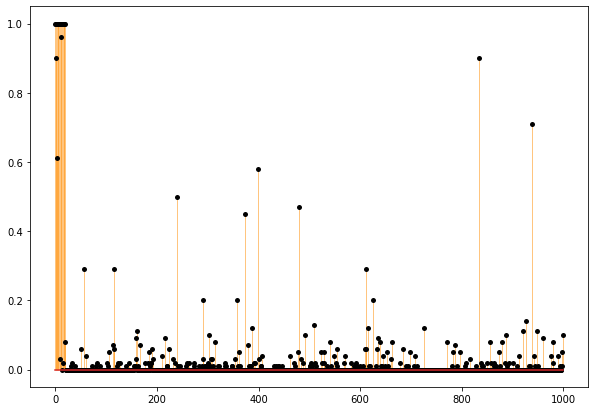

In [16]:
model.plot_selection_frequency()

In [17]:
weight_dist = model.get_weight_distributions(binary=False)
weight_dist

0          1          2         3          4          5    \
mod 1    26.935890   7.132807  19.176385  1.668576   9.456326  65.388304   
mod 2    17.719694   9.018769  15.611161  0.000000   3.118576  59.999753   
mod 3    26.284480   3.038012  24.878150  0.000000  12.218241  67.578374   
mod 4    22.403932   4.366163  21.306078  0.000000   3.676907  56.657261   
mod 5    18.710809   0.190427  20.631618  0.000000  10.020688  56.416468   
mod 6    19.697378   0.187950  24.976113  0.748932  10.462751  55.960697   
mod 7    21.453165   5.625917  21.012465  2.761325  14.213012  61.988305   
mod 8    20.408730   3.769444  24.256298  1.311494   9.394718  62.931392   
mod 9    19.603202   4.315064  25.234186  2.015277   8.143481  62.087309   
mod 10   16.541359   0.000000  18.208476  2.033858   5.043939  54.767691   
mod 11   17.816690   5.502179  21.124619  0.000000   8.835453  61.040300   
mod 12   20.280587   1.981012  19.437734  1.195714   9.614951  62.097226   
mod 13   20.166086   4.104807  20.961833  1.687752   8.068004  51.016930   
mod 14   20.611028   4.867269  20.602853  0.000000  11.970134  59.163162   
mod 15   20.140044   0.424248  19.892099  4.877154  10.189055  57.111464   
mod 16   19.054712   1.836856  12.028990  0.000000   6.386005  59.325028   
mod 17   23.864002   5.702282  25.368083  0.000000  14.601028  66.472923   
mod 18   21.179972  10.099018  22.822828  1.028976  11.861138  64.424431   
mod 19   12.677993   0.000000  19.470384  1.372126   9.175551  58.739734   
mod 20   21.841826   3.622275  22.720657  4.710979  13.684843  64.023712   
mod 21   17.826710   6.594455  20.859337  0.000000   7.183385  50.483278   
mod 22   23.931399   7.393791  17.660521  4.164285  13.031501  62.786149   
mod 23   18.825497   2.358338  23.736265  0.000000  12.629742  63.701534   
mod 24   21.493424   7.038057  23.008687  4.558326  15.130738  67.711227   
mod 25   19.864785   1.607259  25.813803  0.928668  10.408267  62.267019   
mod 26   25.102615   7.519650  23.766217  1.239826  13.936921  65.072630   
mod 27   16.131232   1.155723  14.329637  1.948037   5.565931  63.945024   
mod 28   25.480941   3.450290  21.928993  4.758327  13.729822  61.287618   
mod 29   21.946457   4.903417  16.580938  0.559971  10.938708  66.784447   
mod 30   21.391119   0.000000  25.819722  3.685697  16.169662  62.411455   
mod 31   23.507149   3.658363  22.261260  0.456749   4.346220  56.064234   
mod 32   22.136371   3.963218  26.608626  0.000000  13.799145  63.272278   
mod 33   24.093615   5.040079  23.072070  7.362617  12.893699  65.912749   
mod 34   18.193143   2.622705  24.179212  0.000000  11.686415  61.414710   
mod 35   25.494702   6.030687  19.824187  0.298110   6.031327  65.667888   
mod 36   22.489948   2.524101  27.895323  1.146108  11.567387  65.617563   
mod 37   20.711592   0.000000  17.921396  0.000000   5.085394  63.016930   
mod 38   23.168469   3.612605  16.858928  1.076221  10.865740  63.869470   
mod 39   20.085219   1.818239  18.736195  0.000000   8.170758  55.780992   
mod 40   24.012952   7.041373  22.824981  2.818084  12.930792  63.148873   
mod 41   21.171207   6.671035  18.034323  5.912292  10.491134  66.104739   
mod 42   21.161115   0.659518  18.161668  0.000000   3.876162  54.084267   
mod 43   22.679468   1.835514  22.869951  0.096670   9.585348  63.843533   
mod 44   23.199338   5.000967  25.734841  0.000000  12.233704  59.422522   
mod 45   22.594037   7.836705  26.314995  1.117945  17.701595  66.887131   
mod 46   24.613683   0.000000  17.639504  1.984890  10.295713  65.221651   
mod 47   23.775556   2.430280  24.317346  0.836379  10.603310  66.721045   
mod 48   23.033414   2.742693  22.982597  5.287673  13.735154  56.470117   
mod 49   24.420626   3.763356  20.957217  6.335512  12.350006  65.135029   
mod 50   16.767986   1.733765  19.859147  0.000000   5.324497  51.642432   
mod 51   19.503686   4.004810  15.709397  8.257053   9.122166  57.657803   
mod 52   23.407633   2.531822  21.342628  1.897728  11.805611  

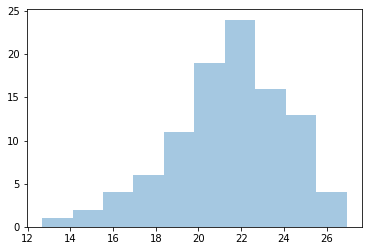

In [18]:
import seaborn as sns
ax = sns.distplot(weight_dist.values[:, 0], kde=False)

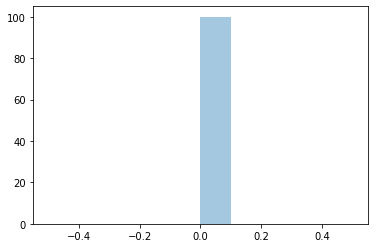

In [19]:
ax = sns.distplot(weight_dist.values[:, 23], kde=False)

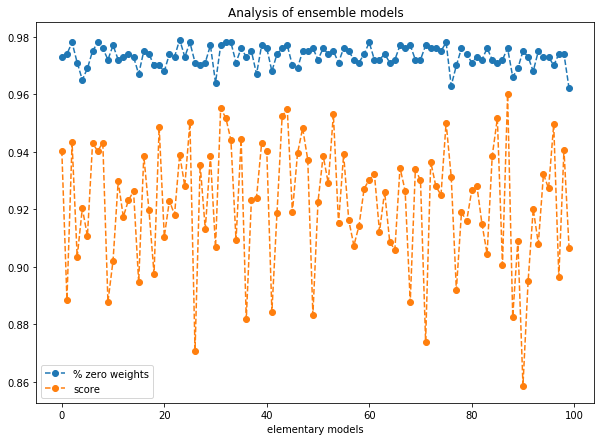

In [20]:
model.plot_elementary_models()

### Check performance using only selected features

To evaluate the performance of RENT, we build a linear regression model based on the features selected with RENT. Performance is measured with the R2 score and the root mean squared error.

In [21]:
#predit test data

# Import what is needed for prediction and evaluation of predictions from test set
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Scale the data accordingly
sc = StandardScaler()
train_data_1 = sc.fit_transform(train_data.iloc[:, selected_features])
test_data_1 = sc.transform(test_data.iloc[:, selected_features])

# Train model with 
prediction_model = LinearRegression().fit(train_data_1, train_labels)

# Print results
print("R2: ", r2_score(test_labels, prediction_model.predict(test_data_1)))
print("RMSEP: ", np.sqrt(mean_squared_error(test_labels, prediction_model.predict(test_data_1))))


R2:  0.9877998634786551
RMSEP:  22.99055256241826


### Validation study regarding the features selected by RENT

Validation study with Student's t-test. Same as in the classification notebook. 

mean VS1 -0.09845094849288531
VS1: p-value for average score from random feature drawing:  4.6289608733126684e-105
VS1: heuristic p-value (how many scores are higher than the RENT score):  0.0
With a significancelevel of  0.05  H0 is rejected.
 
-----------------------------------------------------------
 
Mean VS2 -0.9397924111855602
VS2: p-value for average score from permutation of test labels:  0.0
VS2: heuristic p-value (how many scores are higher than the RENT score):  0.0
With a significancelevel of  0.05  H0 is rejected.


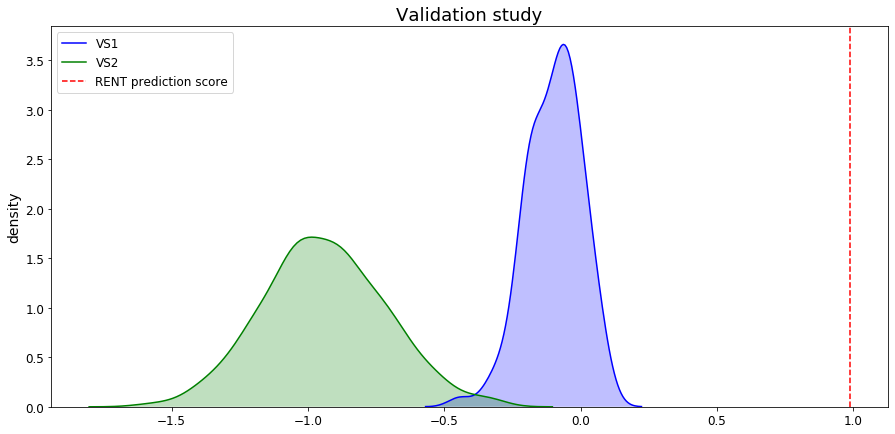

In [22]:
model.plot_validation_study(test_data, test_labels, num_drawings=100, num_permutations=1000, alpha=0.05)

In regression settings, we cannot compute class accuracies for single objects. Therefore, the `.get_summary_objects()` function returns the mean absolute error for each object.

In [23]:
# summary object here: mean of absolut error
model.get_summary_objects()

# test  mean abs error
106    21.0       25.458946
243    24.0       74.682463
4      27.0       35.117069
219    20.0       45.568242
61     22.0       98.545504
124    27.0       55.520137
52     29.0      193.244491
66     27.0       86.921827
26     22.0       78.113565
109    20.0       17.045853
241    28.0       26.551380
222    25.0        9.144199
40     24.0       47.139901
13     31.0       57.095507
3      25.0       55.245344
244    20.0      111.817026
24     19.0       51.648675
30     27.0       73.205246
223    27.0       10.454135
60     24.0       64.786765
56     28.0       64.922467
137    32.0       13.066119
129    23.0       43.455323
19     31.0       33.914977
187    30.0       65.799716
134    24.0       27.578599
54     32.0       14.955171
200    24.0       50.860260
80     27.0       31.131467
51     25.0       64.697509
2      32.0      108.158569
249    28.0       86.618616
104    23.0       11.250024
184    18.0       14.927254
86     20.0       22.037855
10     18.0       14.347901
168    16.0       13.291608
178    31.0        8.639120
233    21.0       25.215951
41     23.0       61.230132
14     32.0       62.992583
27     23.0       26.690331
50     26.0       92.770959
226    15.0       36.174914
20     26.0       12.049460
206    31.0       47.571827
46     25.0       50.502309
171    23.0       90.878443
245    33.0       22.895940
123    20.0       17.760429
145    21.0       10.670592
215    31.0       33.659570
62     21.0       25.075856
138    29.0       12.269510
190    30.0       45.716548
153    19.0        9.661306
135    20.0       93.487874
43     19.0       28.345784
196    24.0      106.824510
144    19.0       83.337050
159    22.0       37.158033
112    25.0       29.000393
182    17.0       40.655353
98     23.0       44.699431
158    18.0       62.527974
93     26.0       36.975527
149    24.0       21.013426
239    23.0       38.870254
113    30.0       67.556229
0      28.0      118.572243
94     26.0       31.403636
95     30.0       13.985194
69     29.0       57.556759
49     32.0       18.636959
48     26.0      142.739229
85     18.0       64.732549
247    22.0       40.772577
141    26.0       15.884187
23     25.0       44.942971
220    24.0       11.366352
143    27.0       19.292372
78     20.0       46.109414
100    26.0       85.052497
131    19.0       89.389127
201    24.0       16.558339
248    23.0       21.857101
6      24.0       38.136221
68     25.0       43.998305
84     36.0       97.687462
121    25.0       80.325280
234    24.0       40.749760
189    25.0       59.767928
212    30.0       29.408687
207    24.0       41.712668
191    28.0       21.491023
91     29.0       23.684195
213    23.0       56.522648
11     25.0       25.623461
119    21.0      117.144352
102    25.0       30.175533
35     22.0       65.873561
57     25.0       58.095358
169    20.0      155.720649
65     32.0      170.579332
1      22.0       13.388272
120    23.0       11.224635
199    17.0       16.042327
42     21.0       15.505851
105    28.0       13.833920
132    21.0       47.945848
236    23.0       51.727353
17     29.0       21.367488
38     36.0       66.625666
133    24.0       55.908648
53     25.0       19.713835
164    31.0       47.736049
214    21.0       44.064689
128    32.0       17.101738
34     24.0       43.342176
28     33.0      133.456723
183    25.0       21.226037
114    23.0       87.848090
163    20.0       16.124181
151    22.0      183.389881
31     28.0       15.590717
205    24.0       42.296541
127    22.0       82.073282
185    23.0       37.099630
221    29.0       11.593542
232    23.0       72.792733
32     22.0       11.924420
167    23.0       62.775253
142    29.0       62.723437
209    26.0       41.373067
147    18.0       29.268805
29     26.0       18.478569
177    22.0       16.395830
99     29.0       39.600924
82     33.0       42.440988
246    24.0      115.252069
175    21.0       10.740407
79     27.0       15.249478
1

### Investigation of absolute prediction errors

With the function `.get_object_errors()` we receive the absolute error for each object over the $K$ models. If an object was not part of the test set in a model, the corresponding value is NaN.

In [24]:
#absolute error for each object/model
error_data = model.get_object_errors()
error_data

mod 1       mod 2       mod 3       mod 4       mod 5       mod 6  \
0           NaN  129.178086         NaN         NaN         NaN         NaN   
1           NaN         NaN         NaN         NaN         NaN         NaN   
2     99.112758         NaN         NaN         NaN         NaN         NaN   
3           NaN   68.611453   55.236188         NaN   67.894725         NaN   
4           NaN         NaN   13.705225         NaN   18.824164         NaN   
6           NaN         NaN         NaN         NaN         NaN         NaN   
9           NaN         NaN         NaN         NaN         NaN         NaN   
10          NaN    1.040461   21.540087         NaN         NaN         NaN   
11    21.522065         NaN         NaN         NaN   26.187659         NaN   
13          NaN         NaN   61.596633         NaN         NaN         NaN   
14          NaN   59.675230         NaN   64.376466         NaN   78.962557   
17    32.821661         NaN   12.299176   21.026662         NaN         NaN   
19          NaN         NaN   22.271299   34.416673         NaN   50.642665   
20     2.843164         NaN         NaN         NaN         NaN         NaN   
21     8.451444         NaN         NaN         NaN   20.559961         NaN   
23          NaN         NaN   52.447620         NaN         NaN         NaN   
24          NaN   83.119201         NaN         NaN   52.612015         NaN   
25          NaN   33.705253         NaN         NaN         NaN   26.248941   
26    60.553205         NaN         NaN         NaN         NaN         NaN   
27          NaN         NaN   25.205325   19.618811         NaN         NaN   
28          NaN         NaN         NaN         NaN         NaN         NaN   
29          NaN   11.286923         NaN   21.775828         NaN         NaN   
30          NaN         NaN         NaN         NaN         NaN   68.835331   
31    10.998435         NaN         NaN         NaN         NaN         NaN   
32     6.867042         NaN         NaN         NaN         NaN         NaN   
34          NaN   42.806108   50.700080         NaN         NaN         NaN   
35          NaN         NaN         NaN         NaN         NaN         NaN   
36          NaN         NaN         NaN         NaN   20.590291         NaN   
38    68.904776   97.796265         NaN   58.889083         NaN         NaN   
39          NaN         NaN    3.140080         NaN    4.655096         NaN   
40          NaN         NaN   40.766273         NaN   54.009181         NaN   
41          NaN   64.853501         NaN         NaN         NaN   62.189519   
42          NaN         NaN         NaN         NaN         NaN   26.147350   
43          NaN         NaN         NaN         NaN         NaN   27.890234   
46          NaN         NaN         NaN   67.060480         NaN   45.186500   
47          NaN         NaN         NaN         NaN   26.602953         NaN   
48          NaN         NaN         NaN         NaN  182.260770  146.992142   
49          NaN   22.939631         NaN   34.538622         NaN         NaN   
50          NaN  116.178479  103.707065   98.471654         NaN   87.074326   
51          NaN   56.779028   65.728880         NaN   88.490054         NaN   
52          NaN         NaN  170.585592  209.005014  208.600982         NaN   
53          NaN   54.097964         NaN         NaN         NaN    8.492817   
54     8.184843         NaN         NaN         NaN   39.034012   21.668447   
56          NaN         NaN         NaN         NaN         NaN         NaN   
57    33.024419         NaN         NaN   70.531418   85.116343         NaN   
58          NaN         NaN         NaN   66.393848         NaN         NaN   
60          NaN   66.154328         NaN         NaN   78.870629         NaN   
61    72.801682   92.030853         NaN  100.361000         NaN         NaN   
62          NaN         NaN         NaN         NaN         NaN         NaN   
65          NaN         NaN         NaN         NaN         

Histogram plots of the absolute errors for different objects.

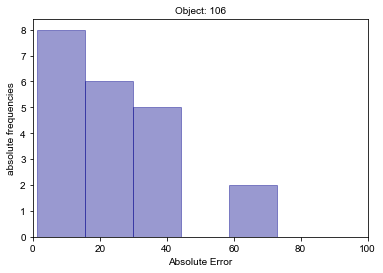

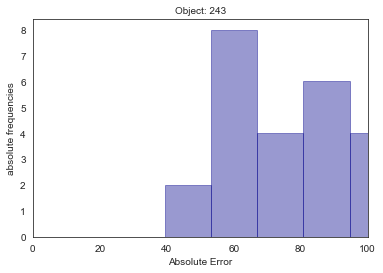

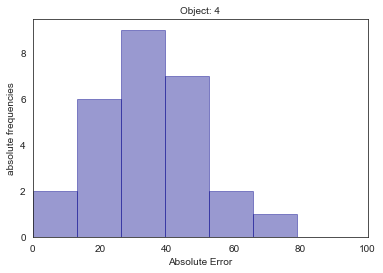

In [25]:
model.plot_object_errors(object_id=[106,243,4])

For regression problems, the PCA scores plot is colored with the mean absolute error.

loo


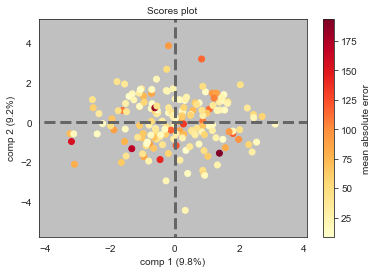

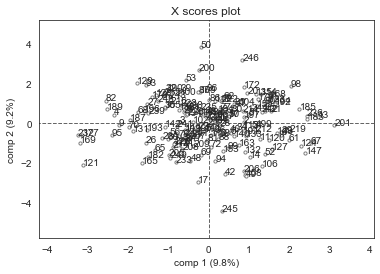

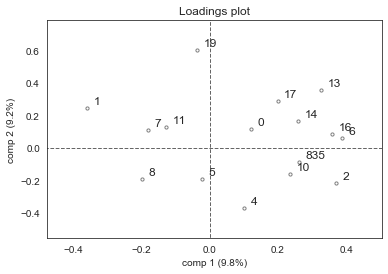

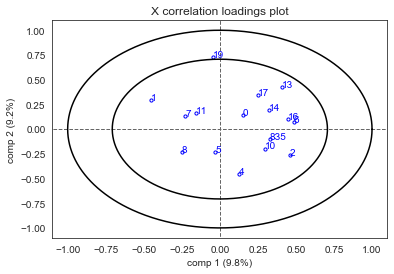

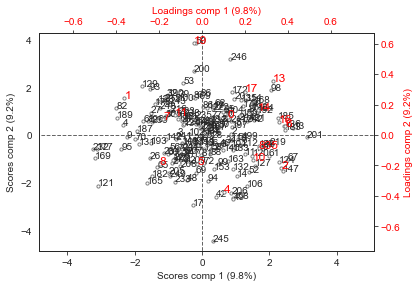

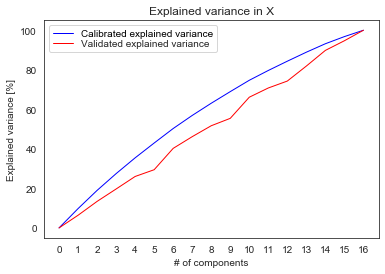

In [26]:
model.plot_object_PCA(cl='continuous', problem="regression")

### Stability analysis of RENT

Measuring the stability of RENT-Regression. The same workflow as in RENT-Classification.

In [27]:
import numpy as np
from sklearn.linear_model import LogisticRegression
import time


M=10 # number of runs 
alpha = 0.05 # level of significance for the confidence interval 
d = len(train_data.columns) # number of features
counts = [2, 5, 10, 50, 100, 300, 500] # values to compare (K)
C, l1 = model.get_enet_params()

# Store outputs in dictionaries
times = {}
stabilities = {}
perf = {}
num_feats = {}

start = time.time()

for count in counts:
    time_count = []
    Z_net = np.zeros((M,d), dtype=np.int8)
    performance = np.zeros(M)
    numFeatures = np.zeros(M)
    
    for i in range(M):
        model = RENT.RENT_Regression(data=train_data, 
                                target=train_labels, 
                                feat_names=train_data.columns, 
                                C= my_C_params, 
                                l1_ratios=my_l1_ratios,
                                autoEnetParSel=True,
                                poly='OFF',
                                testsize_range=(0.25,0.25),
                                K=count,
                                random_state=None,
                                verbose=0)
        model.train()
        features = model.select_features(0.9,0.9,0.975)
        time_count.append(model.get_runtime())
        
        #prediction model
        sc = StandardScaler()
        train = sc.fit_transform(train_data.values[:,features])
        test = sc.transform(test_data.values[:,features])
        ML_model =LinearRegression().fit(train, train_labels)
        performance[i] = r2_score(test_labels, ML_model.predict(test))
        Z_net[i,features] = 1
        numFeatures[i] = len(features)
    
    times[count] = time_count
    stabilities[count] = stability.confidenceIntervals(Z_net, alpha=alpha)
    perf[count] = performance
    num_feats[count] = numFeatures    

end = time.time()

print('Runtime: ', end - start)

Runtime:  1165.805739402771


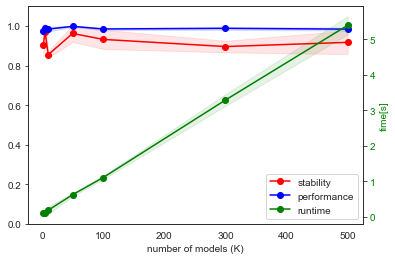

In [28]:
import matplotlib.pyplot as plt
def stability_plot(x_levels, stabilities, accuracies, times):
    stability = np.array(list({k: v['stability'] for k, v in stabilities.items()}.values()))
    stab_error = stability - np.array(list({k: v['lower'] for k, v in stabilities.items()}.values()))
    performance = np.array(list({k: np.mean(v) for k, v in accuracies.items()}.values()))
    performance_error = np.array(list({k: np.std(v) for k, v in accuracies.items()}.values()))
    runtime = np.array(list({k: np.mean(v) for k, v in times.items()}.values()))
    runtime_errors = np.array(list({k: np.std(v) for k, v in times.items()}.values())) 

    fig, ax1 = plt.subplots()
    ax1.set_xlabel('number of models (K)', fontsize=10)
    stab = ax1.plot(x_levels,stability, color="red", label='stability', marker='o')
    ax1.fill_between(x_levels, (stability-stab_error), (stability+stab_error),color="red", alpha=0.1 )
    perf = ax1.plot(x_levels,performance, color="blue", label='performance', marker='o')
    ax1.fill_between(x_levels, (performance-performance_error), (performance+performance_error),color="blue", alpha= 0.1 )
    plt.ylim(0,1.1)
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)
    ax2 = ax1.twinx()
    ax2.set_ylabel('time[s]', color='green', fontsize=10)
    tim = ax2.plot(x_levels,runtime, color="green", label='runtime', marker='o')
    ax2.fill_between(x_levels, (runtime-runtime_errors), (runtime+runtime_errors), color="green", alpha=0.1)
    ax2.tick_params(axis='y', labelcolor="green")

    leg = stab + perf + tim
    labs = [l.get_label() for l in leg]
    ax1.legend(leg, labs, loc=4, fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)


stability_plot(counts, stabilities, perf, times)